# HW3A - Implementing a dashboard as a webpage to visualize NYC air quality across time

In [5]:
# the following package is needed to run the tests from your laptop,
# so that the tests can import the variables defined in this notebook.
#
# pip install ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns

## Q1: Parse XML into Pandas Dataframe

In the hw3 folder you will find the raw XML data ``air_quality.xml`` for the NYC air quality data obtained from [the NYC open data](https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data). 

Your task includes the following:

* Read the data description in the website linked above. Pay special attention to what each column means in the ``Columns (12)`` section.

* Parse the XML data and store it in a Pandas dataframe variable ``df``. Assign appropriate datatypes to eligible columns (e.g. dates, numeric values). Feel free to explore the dataframe and see what it contains.

In [2]:
# Your goal is to populate the following DataFrame:

## ----- TODO: Create a DataFrame from the XML data. ----
## Your code here:
import pandas as pd
import xml.etree.ElementTree as ET

# Parse the XML file
xml_file = "air_quality.xml"  # adjust path if needed
tree = ET.parse(xml_file)
root = tree.getroot()

# Extract data
records = []
for row in root.findall(".//row"):
    record = {}
    for child in row:
        record[child.tag.lower()] = child.text
    records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

# Clean and convert datatypes
df = df[df['unique_id'].notna()].copy()
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

# View result
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 18025 entries, 1 to 18025
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   row             0 non-null      float64       
 1   unique_id       18025 non-null  object        
 2   indicator_id    18025 non-null  object        
 3   name            18025 non-null  object        
 4   measure         18025 non-null  object        
 5   measure_info    18025 non-null  object        
 6   geo_type_name   18025 non-null  object        
 7   geo_join_id     18016 non-null  object        
 8   geo_place_name  18016 non-null  object        
 9   time_period     18025 non-null  object        
 10  start_date      18025 non-null  datetime64[ns]
 11  data_value      18025 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 1.8+ MB
None


,row,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
1,NaN,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409,Southeast Queens,2015,2015-01-01,0.3
2,NaN,221956,386,Ozone (O3),Mean,ppb,UHF34,305307,Upper East Side-Gramercy,Summer 2014,2014-06-01,24.9
3,NaN,221806,386,Ozone (O3),Mean,ppb,UHF34,103,Fordham - Bronx Pk,Summer 2014,2014-06-01,30.7
4,NaN,221836,386,Ozone (O3),Mean,ppb,UHF34,204,East New York,Summer 2014,2014-06-01,32.0
5,NaN,221812,386,Ozone (O3),Mean,ppb,UHF34,104,Pelham - Throgs Neck,Summer 2014,2014-06-01,31.9


## Q2: Annual average air quality by borough

This dataset contains information on New York City air quality surveillance data, across time and NYC geographies. According to the website, air pollution poses a significant environmental threat to urban populations. While everyone is exposed, pollutant emissions, exposure levels, and population vulnerability differ across neighborhoods. 

In the following exercises, we are interested in finding out geographical-temporal trends of the pollutant emissions in NYC. 

### Q2a: Data filtering

Your task includes the following:

* In a new dataframe ``pm_annual_avg``, obtain rows that contains borough-wise, annually-averaged information on the ``Fine particles (PM 2.5)`` indicator. The dataframe should cover information from 2009 to 2022.

* Calculate the annual city average ``Fine particles (PM 2.5)`` indicator values across all boroughs. Append the information to the end of the existing ``pm_annual_avg`` dataframe and assign the appended borough name to be ``New York City``.

*(Hint: you might want to take a look at the unique values for some of the columns. The description by columns on the website could be useful)*


In [5]:
## ------- TODO: Calculate the annual average. --------
# Step 1: Filter for PM 2.5 data from 2009 to 2022
pm_annual_avg = df[
    (df['name'] == 'Fine particles (PM 2.5)') &
    (df['geo_type_name'] == 'Borough') &
    (df['start_date'].dt.year >= 2009) &
    (df['start_date'].dt.year <= 2022)
].copy()

# Step 2: Add 'year' column
pm_annual_avg['year'] = pm_annual_avg['start_date'].dt.year

# Step 3: Compute city-wide annual average
city_avg = (
    pm_annual_avg.groupby('year')['data_value']
    .mean()
    .reset_index()
    .assign(geo_place_name='New York City')
)

# Step 4: Match column structure
city_avg['name'] = 'Fine particles (PM 2.5)'
city_avg['geo_type_name'] = 'Borough'
city_avg['start_date'] = pd.to_datetime(city_avg['year'].astype(str) + '-01-01')

# Add empty or dummy columns if needed to match structure (optional)
# city_avg['unique_id'] = None  # if needed

# Reorder columns to match original structure
columns_to_keep = ['name', 'geo_type_name', 'geo_place_name', 'start_date', 'data_value', 'year']
city_avg = city_avg[columns_to_keep]

# Step 5: Append NYC average to borough data
pm_annual_avg = pd.concat([pm_annual_avg, city_avg], ignore_index=True)


               

### Q2b: Visualization

Your task includes the following:
* Replicate [this lineplot](https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/air-quality/?id=2023#display=trend). Your plot doesn't have to be a 100% replicate, but it should contain similar information, including at least:

    * A title;

    * Axes labels including what the indicator measures and its corresponding unit, both axes in ascending order;

    * Lines with markers colored by boroughs (city average included);

    * A legend for the line colors.

Your plot will be manually graded.



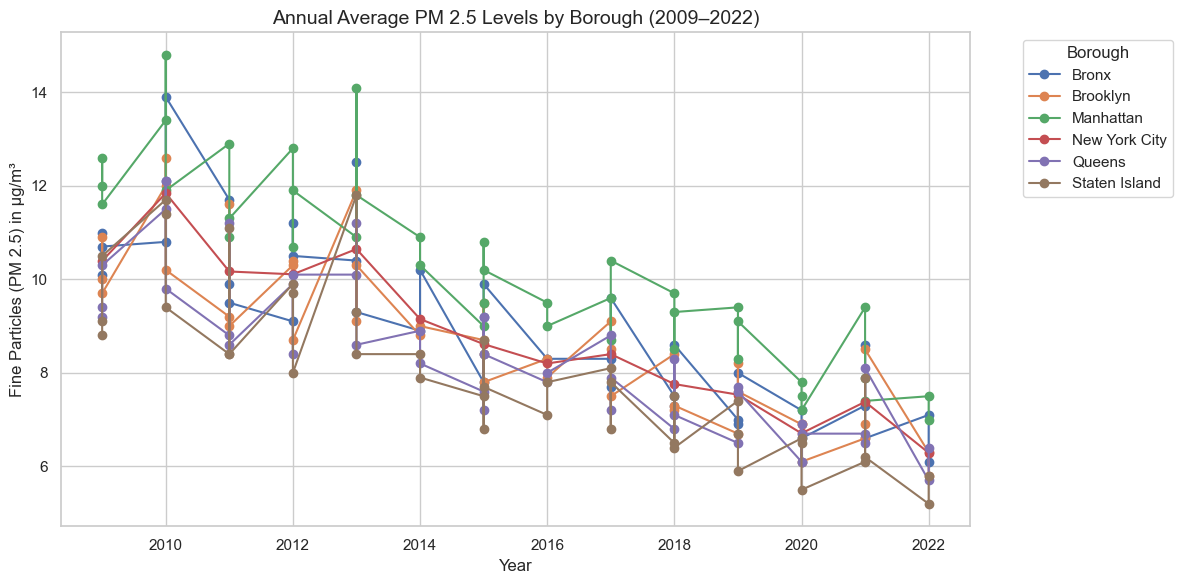

In [6]:
## --------- TODO: Replicate the line plot ---------
## ---------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'year' column exists
if 'year' not in pm_annual_avg.columns:
    pm_annual_avg['year'] = pm_annual_avg['start_date'].dt.year

# Set plot style
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 6))

# Plot one line per borough (including "New York City")
for borough, data in pm_annual_avg.groupby('geo_place_name'):
    data = data.sort_values('year')  # Ensure year is ascending
    plt.plot(
        data['year'],
        data['data_value'],
        marker='o',
        label=borough
    )

# Add title and labels
plt.title("Annual Average PM 2.5 Levels by Borough (2009–2022)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Fine Particles (PM 2.5) in µg/m³", fontsize=12)

# Add legend
plt.legend(title="Borough", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Q3: Hospitalizations due to air quality


Exposure to common air pollutants has been associated with respiratory and cardiovascular diseases. To better understand air quality and its impact on health in the city, we take a closer look at these indicators over time and across NYC neighborhoods.

In the following exercise, you would repeat similar tasks as Q2. 

Your tasks include the following:

* Filter out rows that contain neighborhood-wise information on cardiovascular and respiratory hospitalizations. No need to obtain city average for each period.

* In two subplots side-by-side, plot the cardiovascular and respiratory hospitalization indicators across time and by neighborhood. Assign a different color to each neighborhood. Similar to before, include at least:

    * A title;

    * Axes labels including what these indicators measure and their corresponding units, both axes in ascending order;

    * Lines with markers colored by boroughs (city average included);

    * A legend for the line colors.

You may reuse your code from Q2.

In [21]:
## ------------- TODO: your code here ---------------
# Filter neighborhood-level data
# Fix filters using partial match
df_cardio = df[
    (df['geo_type_name'] == 'Neighborhood') &
    (df['name'].str.contains("Cardiovascular hospitalizations", case=False))
].copy()

df_resp = df[
    (df['geo_type_name'] == 'Neighborhood') &
    (df['name'].str.contains("Respiratory hospitalizations", case=False))
].copy()

# Convert start_date if needed
df_cardio['start_date'] = pd.to_datetime(df_cardio['start_date'], errors='coerce')
df_resp['start_date'] = pd.to_datetime(df_resp['start_date'], errors='coerce')

# Add year column
df_cardio['year'] = df_cardio['start_date'].dt.year
df_resp['year'] = df_resp['start_date'].dt.year

# Confirm it's working
print("Cardiovascular rows after fix:", len(df_cardio))
print("Respiratory rows after fix:", len(df_resp))








Cardiovascular rows after fix: 0
Respiratory rows after fix: 0


/var/folders/yq/pgkldf4s0ng9v2h3wf5m0chw0000gn/T/ipykernel_3501/1691235574.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')
/var/folders/yq/pgkldf4s0ng9v2h3wf5m0chw0000gn/T/ipykernel_3501/1691235574.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')


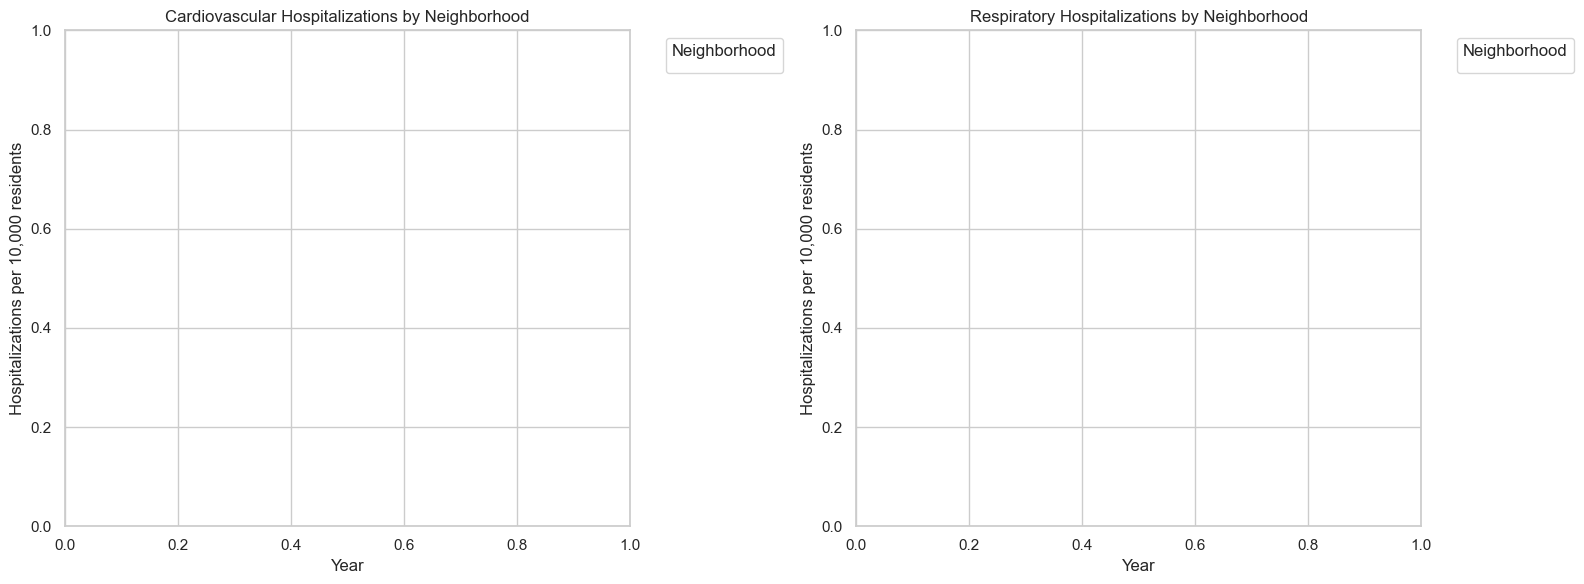

In [17]:
## ------------- TODO: your code here ---------------
## ----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

# -------- Cardiovascular subplot --------
plt.subplot(1, 2, 1)
for neighborhood, data in df_cardio.groupby('geo_place_name'):
    data = data.sort_values('year')
    plt.plot(data['year'], data['data_value'], marker='o', label=neighborhood)

plt.title("Cardiovascular Hospitalizations by Neighborhood")
plt.xlabel("Year")
plt.ylabel("Hospitalizations per 10,000 residents")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')

# -------- Respiratory subplot --------
plt.subplot(1, 2, 2)
for neighborhood, data in df_resp.groupby('geo_place_name'):
    data = data.sort_values('year')
    plt.plot(data['year'], data['data_value'], marker='o', label=neighborhood)

plt.title("Respiratory Hospitalizations by Neighborhood")
plt.xlabel("Year")
plt.ylabel("Hospitalizations per 10,000 residents")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to avoid overlaps
plt.tight_layout()
plt.show()
